# Determine Stations' Neighbourhood and Capacity

## Setup Notebook

In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Get Station Data
First, let's get the station information from `https://tor.publicbikesystem.net`.

In [2]:
response = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = pd.DataFrame(json.loads(response.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon', 'capacity']].astype({'station_id': 'int',})
bikeshare_stations = bikeshare_stations.rename(columns={'station_id': 'Station Id', 
                                                        'name': 'Station Name'})

# View DataFrame
bikeshare_stations.head()

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Wellesley Station Green P,43.664964,-79.383550,17
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11


## Import Toronto Neighbourhoods shapefile
The shapefile for City of Toronto neighbourhood boundaries `'toronto_neighbourhoods.shp'` is included in the assignment 5 directory.

In [3]:
# Write your code here.
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')

# View GeoDataFrame
neighbourhoods.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry
0,2101,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,2102,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,2103,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,2104,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,2105,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


`neighbourhoods` contains a number of columns we don't need and with generic names. Drop all columns except for `'geometry', and 'FIELD_8'`. Next, change the name of column `'FIELD_8'` to `'name'`. Lastly, remove the neighbourhood id from the name. For example, `'Yorkdale-Glen Park (31)'` should become `'Yorkdale-Glen Park'`.  

In [4]:
# Write your code here.
neighbourhoods = neighbourhoods[['FIELD_8','geometry']].rename(columns = {'FIELD_8':'name'})
neighbourhoods['name'] = neighbourhoods['name'].str.split(pat = '(',expand = True)[0]

# View GeoDataFrame
neighbourhoods.head()

,name,geometry
0,Wychwood,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,Yonge-Eglinton,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,Yonge-St.Clair,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,York University Heights,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,Yorkdale-Glen Park,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


In [5]:
# View the first few entries in the "geometry" column
neighbourhoods.geometry.head()

0    POLYGON ((-79.43592 43.68015, -79.43492 43.680...
1    POLYGON ((-79.41096 43.70408, -79.40962 43.704...
2    POLYGON ((-79.39119 43.68108, -79.39141 43.680...
3    POLYGON ((-79.50529 43.75987, -79.50488 43.759...
4    POLYGON ((-79.43969 43.70561, -79.44011 43.705...
Name: geometry, dtype: geometry

It should be noted that neighbourhood geometries are saved as `POLYGON` shapes.

## Convert Station Locations DataFrame to a GeoDataFrame
You'll remember that we imported the station location data as a stantard Pandas DataFrame.

In [6]:
bikeshare_stations.head()

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Wellesley Station Green P,43.664964,-79.383550,17
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11


In [7]:
# Lets create a GeoDataFrame from bikeshare_stations
bikeshare_stations_gdf = gpd.GeoDataFrame(bikeshare_stations, geometry = gpd.points_from_xy(bikeshare_stations['lon'],bikeshare_stations['lat']))

# View DataFrame
bikeshare_stations_gdf.head()

,Station Id,Station Name,lat,lon,capacity,geometry
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35,POINT (-79.39595 43.63983)
1,7001,Wellesley Station Green P,43.664964,-79.383550,17,POINT (-79.38355 43.66496)
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19,POINT (-79.39943 43.66733)
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15,POINT (-79.40276 43.66716)
4,7004,University Ave / Elm St,43.656518,-79.389099,11,POINT (-79.38910 43.65652)


## Generate Simple Plot
We can quickly visualize the data with the plot() method. Let's try it for `neighbourhoods`.

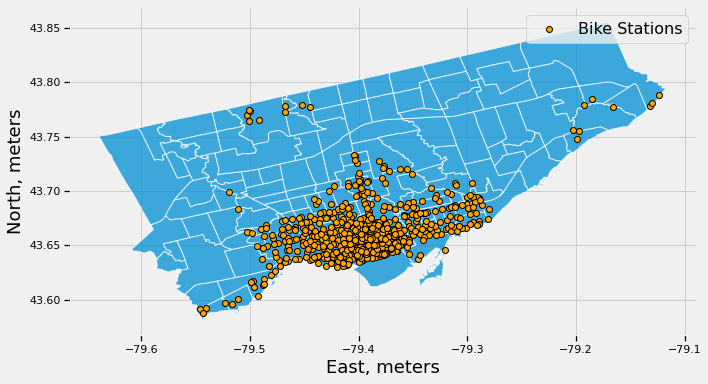

In [15]:
ax = neighbourhoods.plot(figsize=(10, 8), edgecolor='w', alpha=0.75)
bikeshare_stations_gdf.plot(ax=ax, color='orange', edgecolor='k', label='Bike Stations')
plt.legend(fontsize=16)
plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18);

## Create and Export Final csv

In [17]:
test = gpd.sjoin(bikeshare_stations_gdf, neighbourhoods, how = "left", predicate='within')

station_neighbourhoods = test[['Station Id','Station Name','name','capacity']]
station_neighbourhoods = pd.DataFrame(station_neighbourhoods)

station_neighbourhoods.rename(columns={'name':'Neighbourhood'} ,inplace=True)

station_neighbourhoods.to_csv('station_neighbourhoods.csv')
station_neighbourhoods.head(30)

,Station Id,Station Name,Neighbourhood,capacity
0,7000,Fort York Blvd / Capreol Ct,Waterfront Communities-The Island,35
1,7001,Wellesley Station Green P,Church-Yonge Corridor,17
2,7002,St. George St / Bloor St W,University,19
3,7003,Madison Ave / Bloor St W,Annex,15
4,7004,University Ave / Elm St,Kensington-Chinatown,11
5,7005,King St W / York St,Bay Street Corridor,19
6,7006,Bay St / College St (East Side),Bay Street Corridor,11
7,7007,College St / Huron St,Kensington-Chinatown,19
8,7008,Wellesley St / Queen's Park Cres,Bay Street Corridor,19
9,7009,King St E / Jarvis St,Church-Yonge Corridor,25
